In [2]:
%matplotlib inline


# N170 Load and Visualize Data

This example demonstrates loading, organizing, and visualizing ERP response data from the visual N170 experiment. 

Images of faces and houses are shown in a rapid serial visual presentation (RSVP) stream.

The data used is the first subject and first session of the one of the eeg-notebooks N170 example datasets, recorded using the InteraXon MUSE EEG headset (2016 model). 
This session consists of six two-minute blocks of continuous recording.  

We first use the `fetch_datasets` to obtain a list of filenames. If these files are not already present 
in the specified data directory, they will be quickly downloaded from the cloud. 

After loading the data, we place it in an MNE `Epochs` object, and obtain the trial-averaged response. 

The final figure plotted at the end shows the N170 response ERP waveform. 


## Setup



In [3]:
# Some standard pythonic imports
import os
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')

# MNE functions
from mne import Epochs,find_events

# EEG-Notebooks functions
from eegnb.analysis.utils import load_data,plot_conditions
from eegnb.datasets import fetch_dataset

## Load Data

We will use the eeg-notebooks N170 example dataset

Note that if you are running this locally, the following cell will download
the example dataset, if you do not already have it.




In [4]:
eegnb_data_path = os.path.join(os.path.expanduser('~/'),'.eegnb', 'data')    
n170_data_path = os.path.join(eegnb_data_path, 'visual-N170', 'eegnb_examples')

# If dataset hasn't been downloaded yet, download it 
if not os.path.isdir(n170_data_path):
    fetch_dataset(data_dir=eegnb_data_path, experiment='visual-N170', site='eegnb_examples');

subject = 1
session = 1
raw = load_data(subject,session,
                experiment='visual-N170', site='eegnb_examples', device_name='muse2016_bfn',
                data_dir = eegnb_data_path)

['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
Creating RawArray with float64 data, n_channels=5, n_times=93280
    Range : 0 ... 93279 =      0.000 ...   364.371 secs
Ready.
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
Creating RawArray with float64 data, n_channels=5, n_times=76768
    Range : 0 ... 76767 =      0.000 ...   299.871 secs
Ready.
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
Creating RawArray with float64 data, n_channels=5, n_times=76744
    Range : 0 ... 76743 =      0.000 ...   299.777 secs
Ready.
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
Creating RawArray with float64 data, n_channels=5, n_times=76912
    Range : 0 ... 76911 =      0.000 ...   300.434 secs
Ready.
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
Creating RawArray with float64 data, n_channels=5, n_times=76816
    Range : 0 ... 76815 =      0.000 ...   

## Visualize the power spectrum



Effective window size : 8.000 (s)


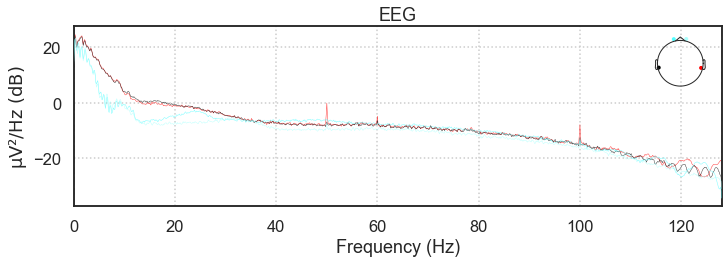

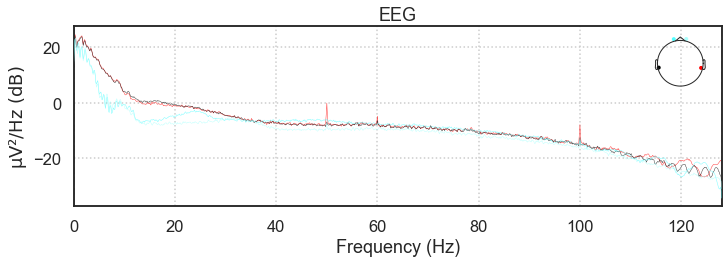

In [5]:
raw.plot_psd()

## Filtering



Filtering raw data in 10 contiguous segments
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB

Effective window size : 8.000 (s)


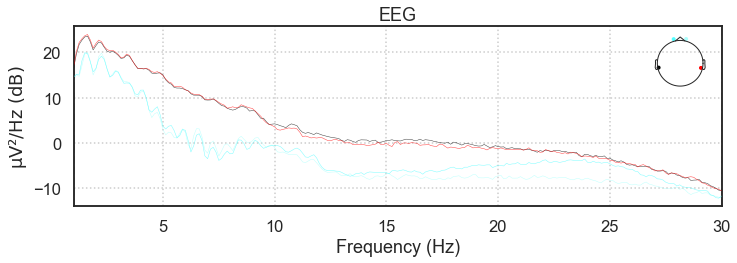

In [6]:
raw.filter(1,30, method='iir')
raw.plot_psd(fmin=1, fmax=30);

## Epoching



In [7]:
# Create an array containing the timestamps and type of each stimulus (i.e. face or house)
events = find_events(raw)
event_id = {'House': 1, 'Face': 2}

# Create an MNE Epochs object representing all the epochs around stimulus presentation
epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=-0.1, tmax=0.6, baseline=None,
                reject={'eeg': 5e-5}, preload=True, 
                verbose=False, picks=[0,1,2,3])
print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)
epochs

3740 events found
Event IDs: [1 2]
sample drop %:  9.919786096256688


Number of events,3369
Events,Face: 1702House: 1667
Time range,-0.102 – 0.602 sec
Baseline,off


## Epoch average



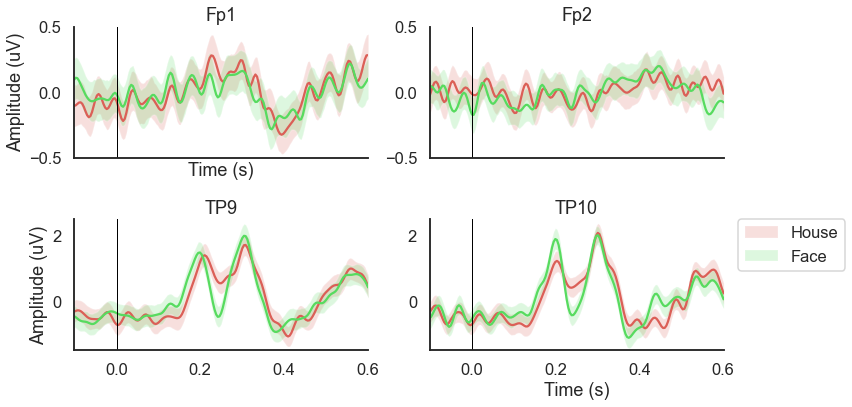

In [8]:
conditions = OrderedDict()
conditions['House'] = [1]
conditions['Face'] = [2]

fig, ax = plot_conditions(epochs, conditions=conditions, 
                          ci=97.5, n_boot=1000, title='',
                          diff_waveform=None, #(1, 2))
                          channel_order=[1,0,2,3]) # reordering of epochs.ch_names according to [[0,2],[1,3]] of subplot axes

# Manually adjust the ylims
for i in [0,2]: ax[i].set_ylim([-0.5,0.5])
for i in [1,3]: ax[i].set_ylim([-1.5,2.5])

## Frequency Oscillations & One Over F (FOOOF)

Effective window size : 0.707 (s)
Effective window size : 0.707 (s)


Text(0.5, 1.0, 'AP Fit')

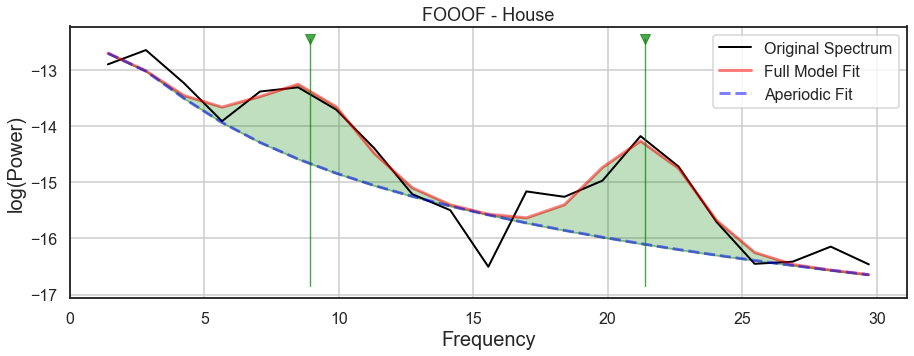

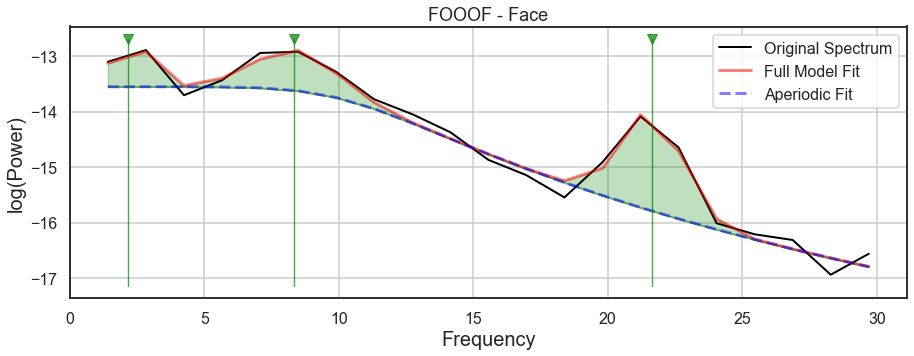

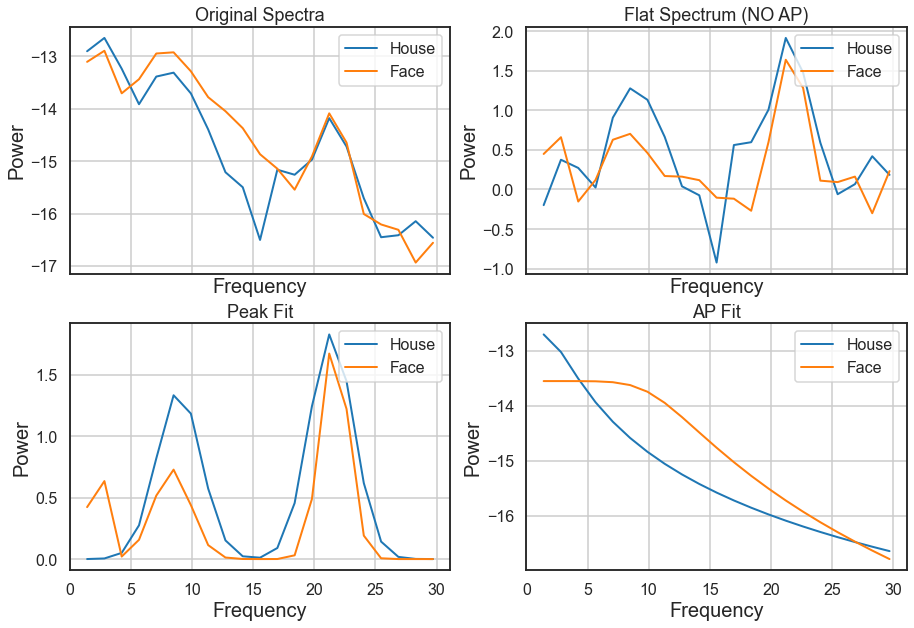

In [30]:
from fooof import FOOOF
import matplotlib.pyplot as plt
from mne.time_frequency import psd_welch
from fooof.plts import plot_spectra

# Averaging epochs by event type (House, Face)
av_epochs = epochs.average(picks=[0,1,2,3], by_event_type=True)

fms = list()
labels = ["House", "Face"]

# Computing PSD for each event type and evaluating FOOOF
for i,e in enumerate(av_epochs):
    power, freq = psd_welch(e, n_fft=len(e.times), n_overlap=len(e.times)/2,\
    proj=False, average='mean', window='hamming')
    
    fms.append(FOOOF(aperiodic_mode='knee', verbose=False))
    fms[i].fit(freq, power[3],freq_range=[1,30])
    
    fig, ax = plt.subplots(figsize=[15, 5])
    fms[i].plot(plot_peaks='line-shade', ax=ax)
    plt.title(f"FOOOF - {labels[i]}")

# Visualization of spectra parametrization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,sharex=True,figsize=[15, 10])
plot_spectra(fms[0].freqs,[fms[0].power_spectrum,fms[1].power_spectrum],ax=ax1,labels=labels)
ax1.set_title("Original Spectra")

plot_spectra(fms[0].freqs,[fms[0]._spectrum_flat,fms[1]._spectrum_flat],ax=ax2,labels=labels)
ax2.set_title("Flat Spectrum (NO AP)")

plot_spectra(fms[0].freqs,[fms[0]._peak_fit,fms[1]._peak_fit],ax=ax3,labels=labels)
ax3.set_title("Peak Fit")

plot_spectra(fms[0].freqs,[fms[0]._ap_fit,fms[1]._ap_fit],ax=ax4,labels=labels)
ax4.set_title("AP Fit")